In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Setting the current working directory
import os; os.chdir('/content/drive/MyDrive/AI_ML/Projects/Capstone-NLP')

### Importing the necessary Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import random

import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report, confusion_matrix, roc_curve

## Load the dataset

In [5]:
#Function 1.1 - Load the dataset

def load_dataset(filename):
  data = pd.read_csv(filename)
  return data

#Function 1.2 - Dataset Cleansing

def data_cleansing_info(data):
  data.drop("Unnamed: 0", axis=1, inplace=True)
  data.rename(columns={'Data':'Date', 'Countries':'Country', 'Accident Level' : 'AccLevel' ,  'Genre':'Gender', 'Employee or Third Party':'Employee type' , 'Potential Accident Level':'Pot_AccLevel', 'Critical Risk':'Cri_Risk'}, inplace=True)
  return data.head(5), data.isnull().sum()

data = load_dataset("IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv")
data.head()

# Preparing the data for our model
# Done some preprocessing on the dataset to the 5 acc level:

# Data Cleansing
# Name Corrections
# Replace Roman numerals to Integers

data_cleansing_info(data)
data.head() #Column names corrected

,Date,Country,Local,Industry Sector,AccLevel,Pot_AccLevel,Gender,Employee type,Cri_Risk,Description
0,1/1/2016 0:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1/2/2016 0:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,1/6/2016 0:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,1/8/2016 0:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,1/10/2016 0:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


## Preparing the data for our model

Done some preprocessing on the dataset to the 5 acc level:
- Data Cleansing
- Name Corrections

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             425 non-null    object
 1   Country          425 non-null    object
 2   Local            425 non-null    object
 3   Industry Sector  425 non-null    object
 4   AccLevel         425 non-null    object
 5   Pot_AccLevel     425 non-null    object
 6   Gender           425 non-null    object
 7   Employee type    425 non-null    object
 8   Cri_Risk         425 non-null    object
 9   Description      425 non-null    object
dtypes: object(10)
memory usage: 33.3+ KB


**The data type of all columns is object**

In [7]:
data1 = data.copy() # Backup

In [8]:
data.columns

Index(['Date', 'Country', 'Local', 'Industry Sector', 'AccLevel',
       'Pot_AccLevel', 'Gender', 'Employee type', 'Cri_Risk', 'Description'],
      dtype='object')

## Dataset Cleaning using NLTK library
- Text normalization

In [9]:
# NLP Import packages
import nltk; nltk.download('wordnet'); nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
import re
from string import punctuation
from wordcloud import STOPWORDS

stop_words =  stopwords.words('english')

def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"ur", " your ", text)
    text = re.sub(r" nd "," and ",text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r" tkts "," tickets ",text)
    text = re.sub(r" c "," can ",text)
    text = re.sub(r" e g ", " eg ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = re.sub(r" u "," you ",text)
    text = text.lower()  # set in lowercase 
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)

In [11]:
#clean the dataset 
data["clean_Description"] = data["Description"].apply(text_cleaning)
data.head(3)

,Date,Country,Local,Industry Sector,AccLevel,Pot_AccLevel,Gender,Employee type,Cri_Risk,Description,clean_Description
0,1/1/2016 0:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,removing drill rod jumbo maintenance superviso...
1,1/2/2016 0:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,ing activation sodium sulphide pump piping unc...
2,1/6/2016 0:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,sub station milpo located level collaborator e...


In [12]:
data.drop('Description', axis=1, inplace=True)
data.rename(columns={'clean_Description':'Description'}, inplace=True)
data.head()

,Date,Country,Local,Industry Sector,AccLevel,Pot_AccLevel,Gender,Employee type,Cri_Risk,Description
0,1/1/2016 0:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,removing drill rod jumbo maintenance superviso...
1,1/2/2016 0:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,ing activation sodium sulphide pump piping unc...
2,1/6/2016 0:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,sub station milpo located level collaborator e...
3,1/8/2016 0:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,approximately nv cx ob7 personnel begin task u...
4,1/10/2016 0:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,approximately circumstance mechanic anthony gr...


In [13]:
pickle.dump( data, open( "clean_data.p", "wb" ))

In [14]:
data = pickle.load( open( "clean_data.p", "rb" ))

### Taking Target input from User

In [15]:
t = ['AccLevel', 'Pot_AccLevel', 'Cri_Risk']
target = input("Please select target 'AccLevel', 'Pot_AccLevel', 'Cri_Risk': ")

Please select target 'AccLevel', 'Pot_AccLevel', 'Cri_Risk': AccLevel


In [16]:
target

'AccLevel'

In [17]:
df = pd.DataFrame(data, columns=[target, 'Description'])
df[target] = df[target].astype('category')
df_backup = df[target]
df.head()

,AccLevel,Description
0,I,removing drill rod jumbo maintenance superviso...
1,I,ing activation sodium sulphide pump piping unc...
2,I,sub station milpo located level collaborator e...
3,I,approximately nv cx ob7 personnel begin task u...
4,IV,approximately circumstance mechanic anthony gr...


In [18]:
data['Cri_Risk'].value_counts()

Others                                       232
Pressed                                       24
Manual Tools                                  20
Chemical substances                           17
Venomous Animals                              16
Cut                                           14
Projection                                    13
Bees                                          10
Fall                                           9
Vehicles and Mobile Equipment                  8
remains of choco                               7
Fall prevention (same level)                   7
Pressurized Systems                            7
Fall prevention                                6
Suspended Loads                                6
Blocking and isolation of energies             3
Liquid Metal                                   3
Pressurized Systems / Chemical Substances      3
Power lock                                     3
Projection of fragments                        2
Electrical Shock    

In [19]:
df[target].value_counts()

I      316
II      40
III     31
IV      30
V        8
Name: AccLevel, dtype: int64

In [20]:
df[target].count()

425

In [21]:
categories = df[target].cat.categories.tolist()
len(categories)

5

## Train/Validation/Test Dataset Split

In [22]:
# Train/Test Dataset Split

# split the data into train and test set
trainval, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# Split train into train-val
df_train, val = train_test_split(trainval, test_size=0.1, random_state=21, shuffle=True)
df_train

,AccLevel,Description
18,I,auxiliary wheel cathode crane g2133 changed ar...
85,I,parking van next cluster wooden sleeper board ...
31,I,level access a2 time engineer trainee planamie...
264,I,time fo mechanic performed removal 1tm engine ...
277,II,performing movement bar make room place calibr...
...,...,...
23,II,loosening a30 truck steering cylinder bolt usi...
373,I,ing marking management point supervision breed...
251,IV,approximately mr wilmer approach c150 drying t...
21,I,raise chamber operator assistant removed drill...


In [23]:
#Balancing the Dataset with UpSampling

from sklearn.utils import resample
df_train[target].value_counts()

categories = df_train[target].cat.categories.tolist()
categories

['I', 'II', 'III', 'IV', 'V']

##Upsampling the Minority Class

In [24]:
#Assiging Classes as per each type

if(target == 'AccLevel'):
  df_train_1 = df_train[df_train[target] == "I"]
  df_train_2 = df_train[df_train[target] == "II"]
  df_train_3 = df_train[df_train[target] == "III"]
  df_train_4 = df_train[df_train[target] == "IV"]
  df_train_5 = df_train[df_train[target] == "V"]

  df_train_2_upsampled = resample(df_train_2, replace = True, n_samples = 223 , random_state = 123)
  df_train_3_upsampled = resample(df_train_3, replace = True, n_samples = 223 , random_state = 123)
  df_train_4_upsampled = resample(df_train_4, replace = True, n_samples = 223 , random_state = 123)
  df_train_5_upsampled = resample(df_train_5, replace = True, n_samples = 223 , random_state = 123)

  df_train_upsampled = pd.concat([df_train_1, df_train_2_upsampled,df_train_3_upsampled, df_train_4_upsampled, df_train_5_upsampled ])
  print(df_train_upsampled[target].value_counts())

  df_train_upsampled_bkup = df_train_upsampled.copy()
  df_train_upsampled_bkup[target].value_counts()

  df_train = df_train_upsampled.copy()

elif(target == 'Pot_AccLevel'):
  df_train_1 = df_train[df_train[target] == "I"]
  df_train_2 = df_train[df_train[target] == "II"]
  df_train_3 = df_train[df_train[target] == "III"]
  df_train_4 = df_train[df_train[target] == "IV"]
  df_train_5 = df_train[df_train[target] == "V"]
  df_train_6 = df_train[df_train[target] == "VI"]

  df_train_1_upsampled = resample(df_train_1, replace = True, n_samples = 143 , random_state = 123)
  df_train_2_upsampled = resample(df_train_2, replace = True, n_samples = 143 , random_state = 123)
  df_train_3_upsampled = resample(df_train_3, replace = True, n_samples = 143 , random_state = 123)
  df_train_5_upsampled = resample(df_train_5, replace = True, n_samples = 143 , random_state = 123)
  df_train_6_upsampled = resample(df_train_6, replace = True, n_samples = 143 , random_state = 123)
 
  df_train_upsampled = pd.concat([df_train_1_upsampled, df_train_2_upsampled,df_train_3_upsampled, df_train_4, df_train_5_upsampled, df_train_6_upsampled ])
  print(df_train_upsampled[target].value_counts())

  df_train_upsampled_bkup = df_train_upsampled.copy()
  df_train_upsampled_bkup[target].value_counts()

  df_train = df_train_upsampled.copy()

else:
  df_train_1 = df_train[df_train[target] == "Others"]
  df_train_2 = df_train[df_train[target] == "Pressed"]
  df_train_3 = df_train[df_train[target] == "Manual Tools"]
  df_train_4 = df_train[df_train[target] == "Chemical substances"]
  df_train_5 = df_train[df_train[target] == "Venomous Animals"]
  df_train_6 = df_train[df_train[target] == "Cut"]
  df_train_7 = df_train[df_train[target] == "Projection"]
  df_train_8 = df_train[df_train[target] == "Bees"]
  df_train_9 = df_train[df_train[target] == "Fall"]
  df_train_10 = df_train[df_train[target] == "Vehicles and Mobile Equipment"]
  df_train_11 = df_train[df_train[target] == "Pressurized Systems"]
  df_train_12 = df_train[df_train[target] == "remains of choco"]
  df_train_13 = df_train[df_train[target] == "Fall prevention (same level)"]
  df_train_14 = df_train[df_train[target] == "Suspended Loads"]
  df_train_15= df_train[df_train[target] == "Fall prevention"]
  df_train_16 = df_train[df_train[target] == "Pressurized Systems / Chemical Substances"]
  df_train_17 = df_train[df_train[target] == "Blocking and isolation of energies"]
  df_train_18 = df_train[df_train[target] == "Liquid Metal"]
  df_train_19 = df_train[df_train[target] == "Power lock"]
  df_train_20 = df_train[df_train[target] == "Machine Protection"]
  df_train_21 = df_train[df_train[target] == "Electrical Shock"]
  df_train_22 = df_train[df_train[target] == "Projection of fragments"]
  df_train_23 = df_train[df_train[target] == "Confined space"]
  df_train_24 = df_train[df_train[target] == "Burn"]
  #df_train_25 = df_train[df_train[target] == "Poll"]
  df_train_26 = df_train[df_train[target] == "Projection/Choco"]
  df_train_27 = df_train[df_train[target] == "Electrical installation"]
  #df_train_28 = df_train[df_train[target] == "Projection/Burning"]
  #df_train_29 = df_train[df_train[target] == "Projection/Manual Tools"]
  #df_train_30 = df_train[df_train[target] == "\nNot applicable"]
  #df_train_31 = df_train[df_train[target] == "Traffic"]
  #df_train_32 = df_train[df_train[target] == "Individual protection equipment"]
  #df_train_33 = df_train[df_train[target] == "Plates"]
  

  #df_train_1_upsampled = resample(df_train_1, replace = True, n_samples = 232 , random_state = 123)
  df_train_2_upsampled = resample(df_train_2, replace = True, n_samples = 232 , random_state = 123)
  df_train_3_upsampled = resample(df_train_3, replace = True, n_samples = 232 , random_state = 123)
  df_train_4_upsampled = resample(df_train_4, replace = True, n_samples = 232 , random_state = 123)
  df_train_5_upsampled = resample(df_train_5, replace = True, n_samples = 232 , random_state = 123)
  df_train_6_upsampled = resample(df_train_6, replace = True, n_samples = 232 , random_state = 123)
  df_train_7_upsampled = resample(df_train_7, replace = True, n_samples = 232 , random_state = 123)
  df_train_8_upsampled = resample(df_train_8, replace = True, n_samples = 232 , random_state = 123)
  df_train_9_upsampled = resample(df_train_9, replace = True, n_samples = 232 , random_state = 123)
  df_train_10_upsampled = resample(df_train_10, replace = True, n_samples = 232 , random_state = 123)
  df_train_11_upsampled = resample(df_train_11, replace = True, n_samples = 232 , random_state = 123)
  df_train_12_upsampled = resample(df_train_12, replace = True, n_samples = 232 , random_state = 123)
  df_train_13_upsampled = resample(df_train_13, replace = True, n_samples = 232 , random_state = 123)
  df_train_14_upsampled = resample(df_train_14, replace = True, n_samples = 232 , random_state = 123)
  df_train_15_upsampled = resample(df_train_15, replace = True, n_samples = 232 , random_state = 123)
  df_train_16_upsampled = resample(df_train_16, replace = True, n_samples = 232 , random_state = 123)
  df_train_17_upsampled = resample(df_train_17, replace = True, n_samples = 232 , random_state = 123)
  df_train_18_upsampled = resample(df_train_18, replace = True, n_samples = 232 , random_state = 123)
  df_train_19_upsampled = resample(df_train_19, replace = True, n_samples = 232 , random_state = 123)
  df_train_20_upsampled = resample(df_train_20, replace = True, n_samples = 232 , random_state = 123)
  df_train_21_upsampled = resample(df_train_21, replace = True, n_samples = 232 , random_state = 123)
  df_train_22_upsampled = resample(df_train_22, replace = True, n_samples = 232 , random_state = 123)
  df_train_23_upsampled = resample(df_train_23, replace = True, n_samples = 232 , random_state = 123)
  df_train_24_upsampled = resample(df_train_24, replace = True, n_samples = 232 , random_state = 123)
  #df_train_25_upsampled = resample(df_train_25, replace = True, n_samples = 232 , random_state = 123)
  df_train_26_upsampled = resample(df_train_26, replace = True, n_samples = 232 , random_state = 123)
  df_train_27_upsampled = resample(df_train_27, replace = True, n_samples = 232 , random_state = 123)
  #df_train_28_upsampled = resample(df_train_28, replace = True, n_samples = 232 , random_state = 123)
  #df_train_29_upsampled = resample(df_train_29, replace = True, n_samples = 232 , random_state = 123)
  # df_train_30_upsampled = resample(df_train_30, replace = True, n_samples = 232 , random_state = 123)
  # df_train_31_upsampled = resample(df_train_31, replace = True, n_samples = 232 , random_state = 123)
  # df_train_32_upsampled = resample(df_train_32, replace = True, n_samples = 232 , random_state = 123)
  # df_train_33_upsampled = resample(df_train_33, replace = True, n_samples = 232 , random_state = 123)
 
  df_train_upsampled = pd.concat([df_train_1, df_train_2_upsampled,df_train_3_upsampled, df_train_4, df_train_5_upsampled, df_train_6_upsampled, df_train_7_upsampled, df_train_8_upsampled, df_train_9_upsampled, df_train_10_upsampled, df_train_11_upsampled,  df_train_12_upsampled,df_train_13_upsampled, df_train_14, df_train_15_upsampled, df_train_16_upsampled, df_train_17_upsampled, df_train_18_upsampled, df_train_19_upsampled, df_train_20_upsampled, df_train_21_upsampled, df_train_22_upsampled, df_train_23_upsampled, df_train_24_upsampled, df_train_26_upsampled, df_train_27_upsampled ])
  print(df_train_upsampled[target].value_counts())

  df_train_upsampled_bkup = df_train_upsampled.copy()
  df_train_upsampled_bkup[target].value_counts()

  df_train = df_train_upsampled.copy()



V      223
IV     223
III    223
II     223
I      223
Name: AccLevel, dtype: int64


#Using Embedding: Universal Sentence Encoder
- The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

- The input is variable length English text and the output is a 512 dimensional vector. The universal-sentence-encoder-large model is trained with a Transformer encoder.

- This module is about 800MB.

In [25]:
%tensorflow_version 1.x

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from tensorflow import keras
import keras.layers as layers
from keras.models import Model
from keras import backend as K

np.random.seed(10)

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

TensorFlow 1.x selected.


Using TensorFlow backend.


In [26]:
#module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [27]:
# # Compute a representation for each message, showing various lengths supported.
# word = "Elephant"
# sentence = "I am a sentence for which I would like to get its embedding."
# paragraph = (
#     "Universal Sentence Encoder embeddings also support short paragraphs. "
#     "There is no hard limit on how long the paragraph is. Roughly, the longer "
#     "the more 'diluted' the embedding will be.")
# messages = [word, sentence, paragraph]

# # Reduce logging output.
# tf.logging.set_verbosity(tf.logging.ERROR)

# with tf.Session() as session:
#   session.run([tf.global_variables_initializer(), tf.tables_initializer()])
#   message_embeddings = session.run(embed(messages))

#   for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
#     print("Message: {}".format(messages[i]))
#     print("Embedding size: {}".format(len(message_embedding)))
#     message_embedding_snippet = ", ".join(
#         (str(x) for x in message_embedding[:3]))
#     print("Embedding: [{}, ...]\n".format(message_embedding_snippet))
 

In [28]:
# # Compute a representation for each message, showing various lengths supported.
# messages = ["That band rocks!", "That song is really cool."]

# with tf.Session() as session:
#   session.run([tf.global_variables_initializer(), tf.tables_initializer()])
#   message_embeddings = session.run(embed(messages))
# message_embeddings

In [29]:
#Get the Embed Size

embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value
embed_size

# Get the Category Counts
category_counts = len(df_train[target].cat.categories)
category_counts

#Converting train dataset to correct format

train_text = df_train['Description'].tolist()
train_text = np.array(train_text, dtype=object)[:, np.newaxis]

train_label = np.asarray(pd.get_dummies(df_train[target]), dtype = np.int8)
train_label[8]
print(train_text.shape)

#Converting test dataset to correct format

test_text = df_test['Description'].tolist()
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = np.asarray(pd.get_dummies(df_test[target]), dtype = np.int8)
test_label[:3]
print(test_text.shape)


#Converting validation dataset to correct format

val_text = val["Description"].tolist()
val_text = np.array(val_text, dtype=object)[:, np.newaxis]
val_label = np.asarray(pd.get_dummies(val[target]), dtype = np.int8)
val_label[:3]
print(val_text.shape)

(1115, 1)
(85, 1)
(34, 1)


In [30]:
from keras.layers import Input, LSTM, Dense, Activation, Dropout,Embedding
from tensorflow.keras.layers import Flatten, Dense

def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [31]:
#!pip install keras-self-attention

In [32]:
#from keras_self_attention import SeqSelfAttention

https://stackoverflow.com/questions/60809068/error-output-of-the-tf-hub-layers-embedding-with-conv-or-rnn
https://stackoverflow.com/questions/42918446/how-to-add-an-attention-mechanism-in-keras?answertab=votes#tab-top


##Model Building

- Using Convolution with LSTM 

### Compile the model 
- Use Optimizer as Adam
- Use **categorical_crossentropy** as loss
- Use **categorical_accuracy** as metrics

In [96]:
#Model Building

from keras.layers import Dense, Embedding, LSTM, Dropout, MaxPooling1D, Conv1D, Bidirectional

input_text = layers.Input(shape=(1,), dtype=tf.string)
print(input_text.shape)
embedding = layers.Lambda(UniversalEmbedding,output_shape=(embed_size,))(input_text)
print(embedding.shape)
reshape = layers.Reshape(target_shape=(1, 512 ))(embedding)
print(reshape.shape)
drop = (Dropout(0.25))(reshape)
cnvl = (Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1))(drop)
lstm=LSTM(units=128,return_sequences=False)(cnvl)
#lstm = (Bidirectional(LSTM(units=100, return_sequences=False, recurrent_dropout=0.1)))(drop)
#attn = SeqSelfAttention(attention_activation='softmax')(lstm)
#attn = (Activation("softmax"))(lstm)
dense = layers.Dense(256, activation='relu')(lstm)
print(dense.shape)

pred = layers.Dense(category_counts, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

#print model summary
model.summary()

(?, 1)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(?, 512)
(?, 1, 512)
(?, 256)
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
lambda_14 (Lambda)           (None, 512)               0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 1, 512)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 256)            655616    
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_19 (Dense)            

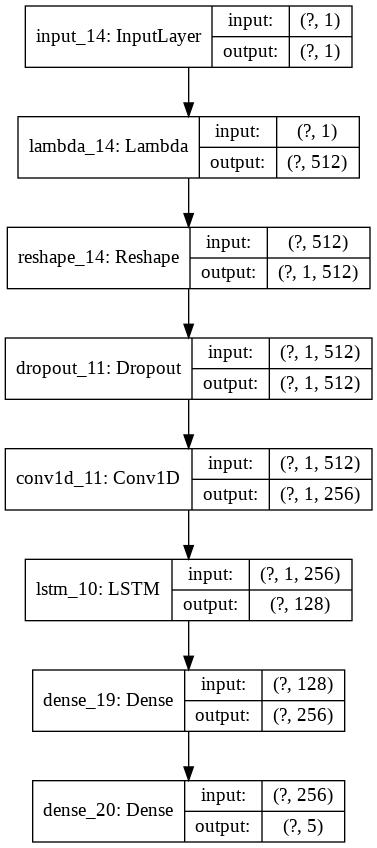

In [97]:
tf.keras.utils.plot_model(model, show_shapes = True)

##Model Training

In [100]:
#Model Training

with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  # Adding callbacks
  es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 0)  
  #mc = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
  #logdir = 'log'; tb = TensorBoard(logdir, histogram_freq = 1)
  #lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5)
  
  callbacks = [es] #mc, lr_r] #https://stackoverflow.com/questions/58030543/list-of-keras-callbacks-generates-error-tuple-object-has-no-attribute-set-mo
  
  h = model.fit(train_text, train_label, validation_data=(val_text, val_label), epochs=30, batch_size=32, callbacks = callbacks)
  model.save_weights('./model_lstm.h5')

Train on 1115 samples, validate on 34 samples
Epoch 1/30
1115/1115 [==============================] - 6s 6ms/step - loss: 1.5485 - categorical_accuracy: 0.3480 - val_loss: 1.4393 - val_categorical_accuracy: 0.1765
Epoch 2/30
1115/1115 [==============================] - 2s 2ms/step - loss: 1.0063 - categorical_accuracy: 0.6126 - val_loss: 1.3766 - val_categorical_accuracy: 0.3529
Epoch 3/30
1115/1115 [==============================] - 2s 1ms/step - loss: 0.6498 - categorical_accuracy: 0.7300 - val_loss: 1.3620 - val_categorical_accuracy: 0.3529
Epoch 4/30
1115/1115 [==============================] - 2s 1ms/step - loss: 0.4838 - categorical_accuracy: 0.8233 - val_loss: 1.1003 - val_categorical_accuracy: 0.4412
Epoch 5/30
1115/1115 [==============================] - 2s 1ms/step - loss: 0.3993 - categorical_accuracy: 0.8529 - val_loss: 1.6295 - val_categorical_accuracy: 0.4412
Epoch 00005: early stopping


##Plotting the Training & Test Accuracy and Loss

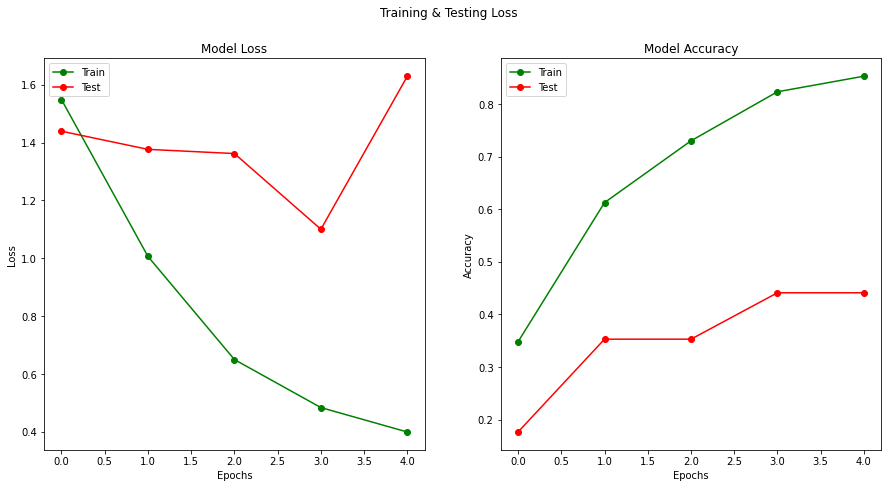

In [101]:
#Plotting the Training & Test Accuracy and Loss

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7.2))
f.suptitle('Training & Testing Loss')

ax1.plot(h.history['loss'], 'go-' , label = 'Train')
ax1.plot(h.history['val_loss'],  'ro-' , label = 'Test')
ax1.set_title('Model Loss')
ax1.legend(['Train', 'Test'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(h.history['categorical_accuracy'], 'go-', label = 'Train')
ax2.plot(h.history['val_categorical_accuracy'], 'ro-' , label = 'Test')
ax2.set_title('Model Accuracy')
ax2.legend(['Train', 'Test'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

plt.show()

 ## Plot the Classification Report and Overall Accuracy

In [102]:
#Print the Classification Report and Overall Accuracy

from sklearn import metrics
from sklearn.metrics import classification_report

# Evaluate the model
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  loss, categorical_accuracy = model.evaluate(test_text, test_label, verbose = 0)
  print('Overall Accuracy: {}'.format(categorical_accuracy * 100))
  y_pred = model.predict(test_text, batch_size=10, verbose=1)
  y_pred_bool = np.argmax(y_pred, axis=1)
  y_test_bool = np.argmax(test_label, axis=1)
  print(classification_report(y_test_bool, y_pred_bool))


model_score = metrics.accuracy_score(y_test_bool, y_pred_bool)
print(model_score * 100)

Overall Accuracy: 63.52941393852234
85/85 [==============================] - 4s 50ms/step
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        68
           1       0.17      0.50      0.25         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2

    accuracy                           0.64        85
   macro avg       0.20      0.25      0.21        85
weighted avg       0.68      0.64      0.65        85



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


63.52941176470588


##Plot the confusion matrix

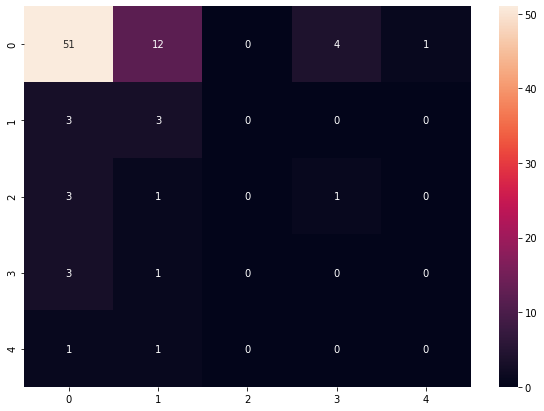

In [103]:
#Print Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_bool, y_pred_bool)

#Plot the  Confusion Matrix

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [104]:
#Prediction with Raw Text

#new_text = ["In what year did the titanic sink ?", "What is the highest peak in California ?", "Who invented the light bulb ?"]
new_text = ["In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of â€‹â€‹the left foot of the collaborator causing the injury.", "",""]
new_text = np.array(new_text, dtype=object)[:, np.newaxis]
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model_lstm.h5')  
  predicts = model.predict(new_text, batch_size=32)

print(predicts)

categories = df_train[target].cat.categories.tolist()
predict_logits = predicts.argmax(axis=1)
predict_labels = [categories[logit] for logit in predict_logits]
predict_labels[0]

[[3.1620210e-01 1.6465994e-02 6.4256060e-01 2.4535997e-02 2.3531496e-04]
 [2.2708412e-01 7.1725607e-01 4.3502428e-02 1.1413768e-02 7.4360031e-04]
 [2.2708412e-01 7.1725607e-01 4.3502428e-02 1.1413768e-02 7.4360031e-04]]


'III'